**IMPORTING LIBRARIES**

In [ ]:
from collections import Counter
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import PowerTransformer
from sklearn.preprocessing import MinMaxScaler

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import GridSearchCV
from imblearn.metrics import geometric_mean_score
from sklearn.metrics import make_scorer
from sklearn.dummy import DummyClassifier

from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from imblearn.combine import SMOTEENN
from imblearn.under_sampling import EditedNearestNeighbours

from scipy.stats import kurtosis, skew
from scipy import stats

**READING INPUT DATA**

In [ ]:
FILE_PATH = "/content/oil-spill.csv"

oil_df = pd.read_csv(FILE_PATH, header=None)

oil_df.drop([0,22], axis=1, inplace=True)

In [ ]:
class color:
   PURPLE = '\033[95m'
   CYAN = '\033[96m'
   DARKCYAN = '\033[36m'
   BLUE = '\033[94m'
   GREEN = '\033[92m'
   YELLOW = '\033[93m'
   RED = '\033[91m'
   BOLD = '\033[1m'
   UNDERLINE = '\033[4m'
   END = '\033[0m'

def DataDesc(df):
    print(f"Dataset Shape: {df.shape}")
    summary = pd.DataFrame(df.dtypes,columns=['dtypes'])
    summary = summary.reset_index()
    summary['Name'] = summary['index']
    summary = summary[['Name','dtypes']]
    summary['Missing'] = df.isnull().sum().values
    summary['Uniques'] = df.nunique().values
    summary['First Value'] = df.loc[0].values
    summary['Second Value'] = df.loc[1].values
    summary['Third Value'] = df.loc[2].values

    for name in summary['Name'].value_counts().index:
        summary.loc[summary['Name'] == name, 'Entropy'] = round(stats.entropy(df[name].value_counts(normalize=True), base=2),2)

    return summary

def CalOutliers(df_num):
    data_mean, data_std = np.mean(df_num), np.std(df_num)

    cut = data_std * 3

    lower, upper = data_mean - cut, data_mean + cut

    outliers_lower = [x for x in df_num if x < lower]
    outliers_higher = [x for x in df_num if x > upper]
    outliers_total = [x for x in df_num if x < lower or x > upper]

    outliers_removed = [x for x in df_num if x > lower and x < upper]

    print(color.BOLD+f'Lower outliers: {len(outliers_lower)}'+ color.END)
    print(color.BOLD+f'Upper outliers: {len(outliers_higher)}'+ color.END)
    print(color.BOLD+f'Non - outliers: {len(outliers_removed)}'+ color.END)
    print(color.BOLD+f'% of Outliers : {round((len(outliers_total) / len(outliers_removed) )*100, 4)}'+ color.END )

**EXPLORING DATA**

In [ ]:
DataDesc(oil_df)

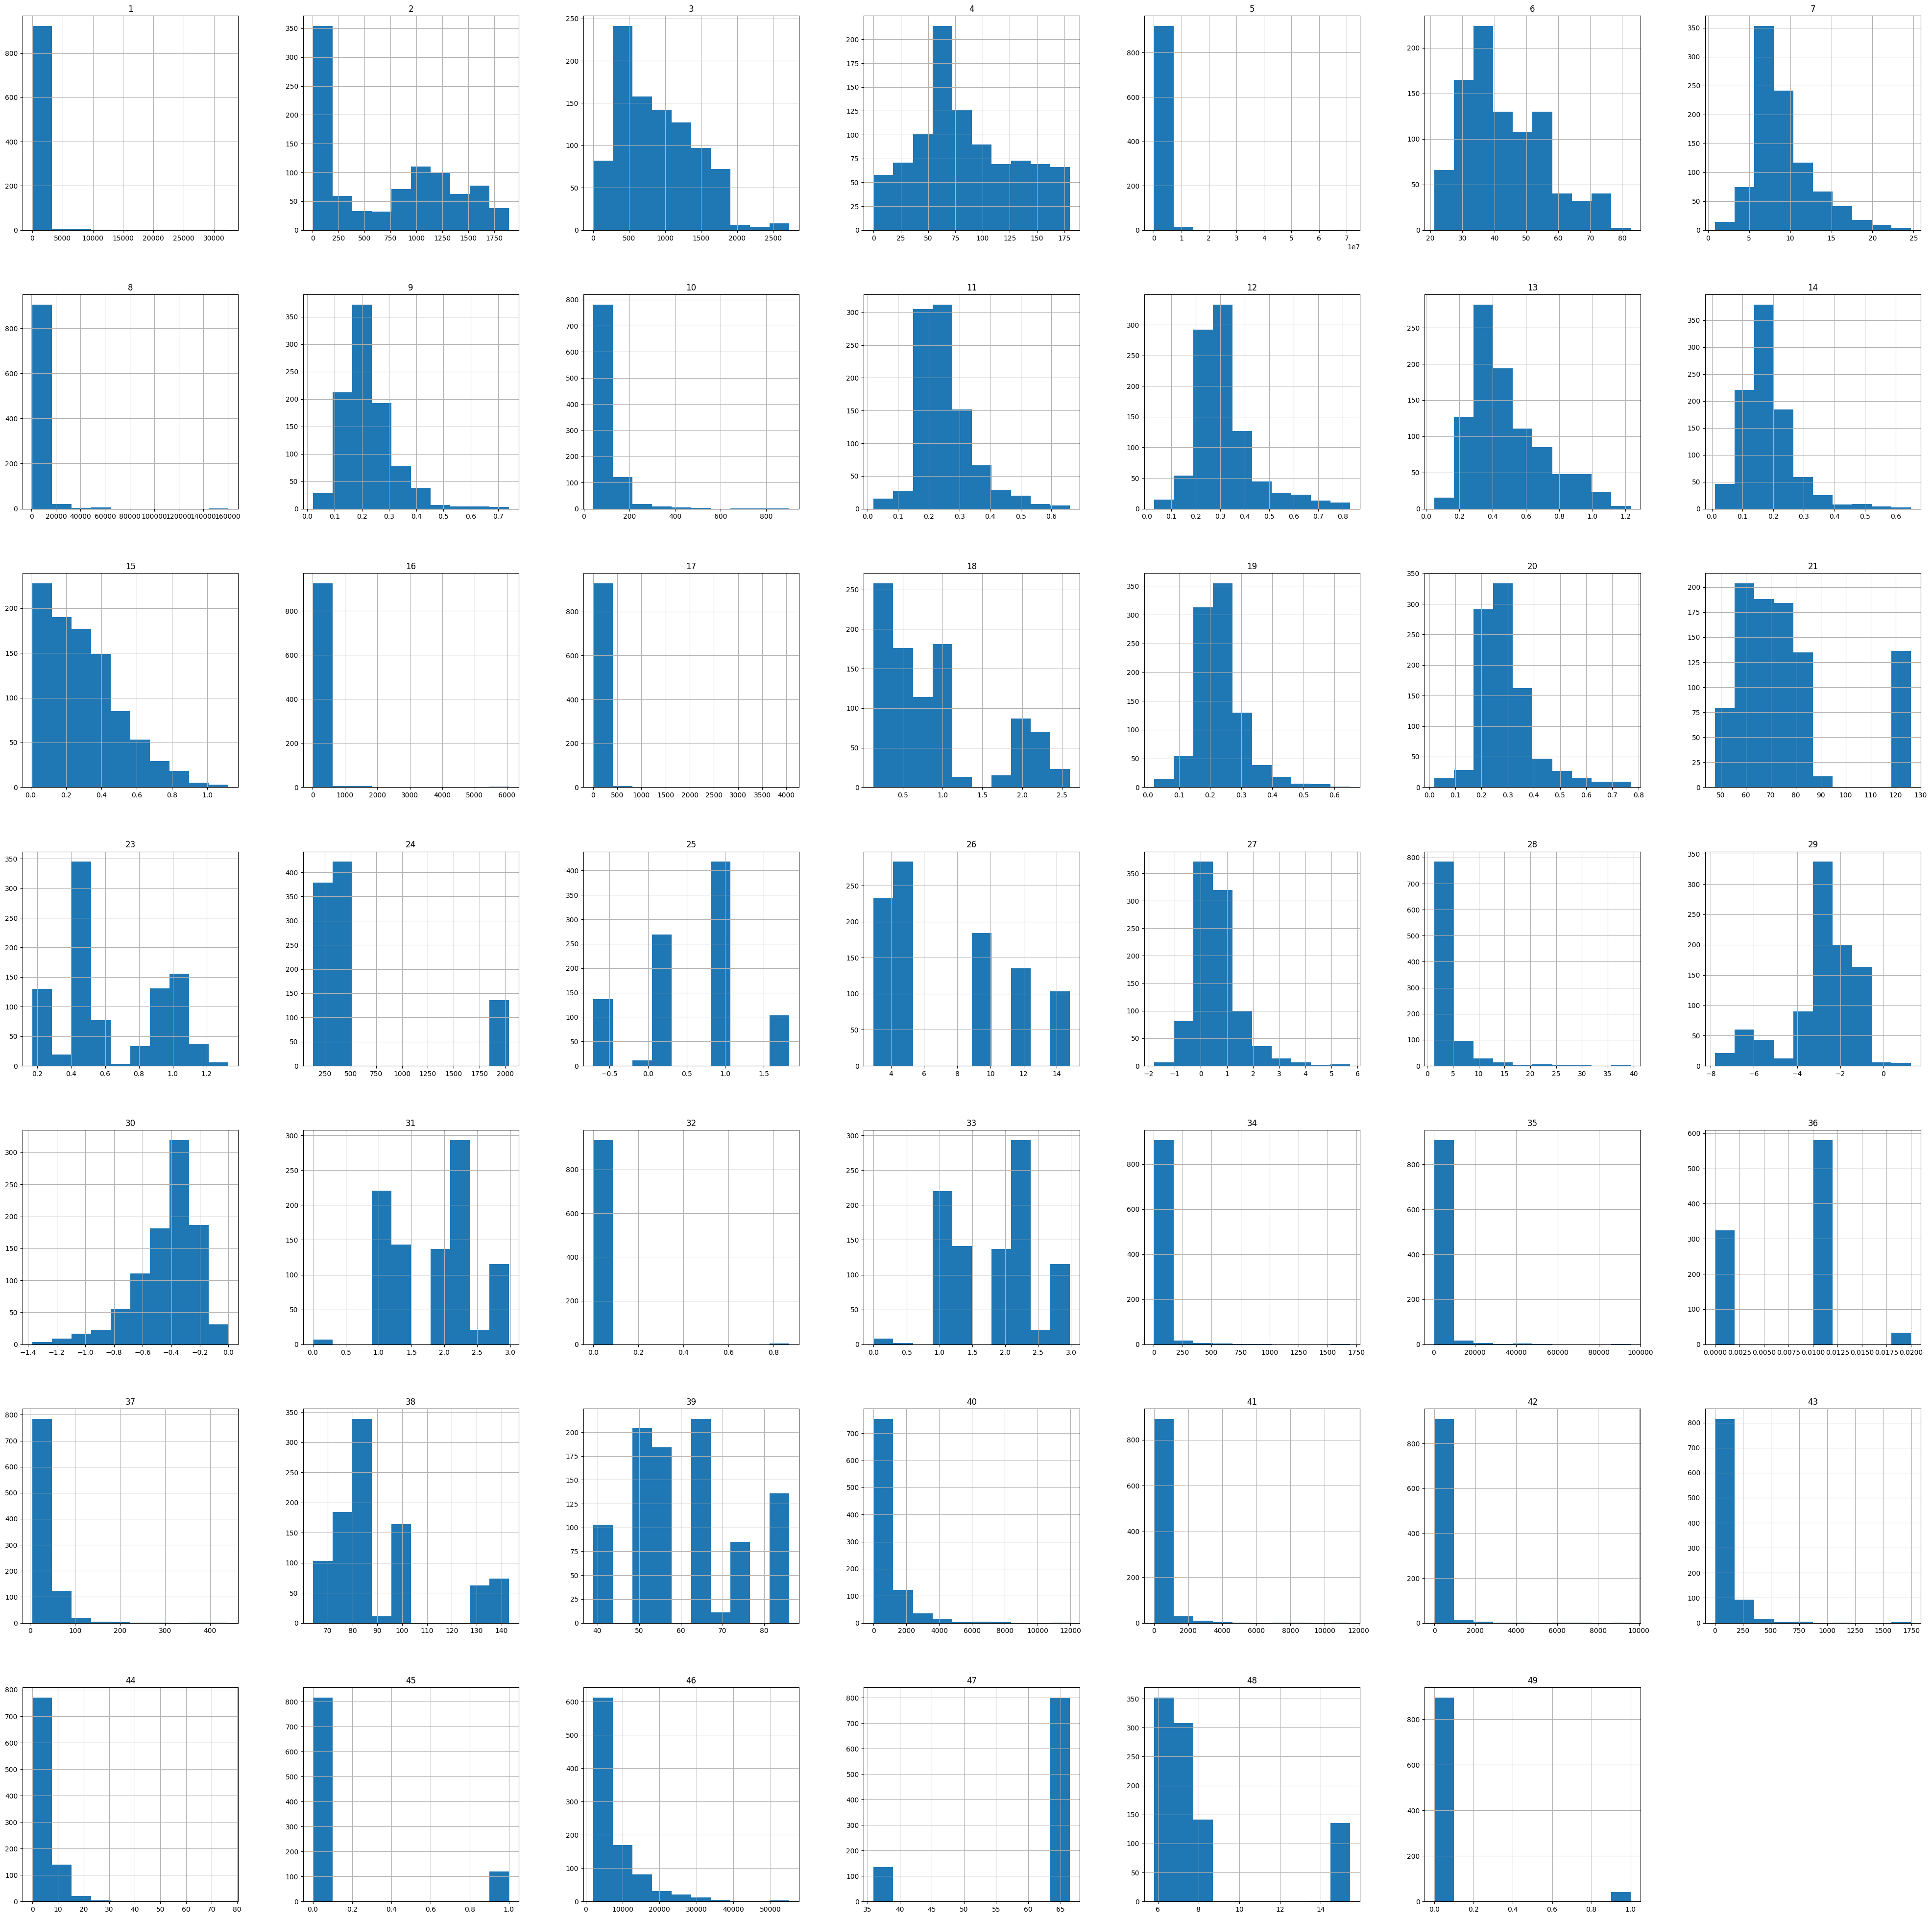

In [ ]:
fig = plt.figure(figsize=(50,50))
ax = fig.gca()

_ = oil_df.hist(ax=ax)

**TARGET VARIABLE DISTRIBUTION**

Class=1, Count=41, Percentage=4.376%
Class=0, Count=896, Percentage=95.624%


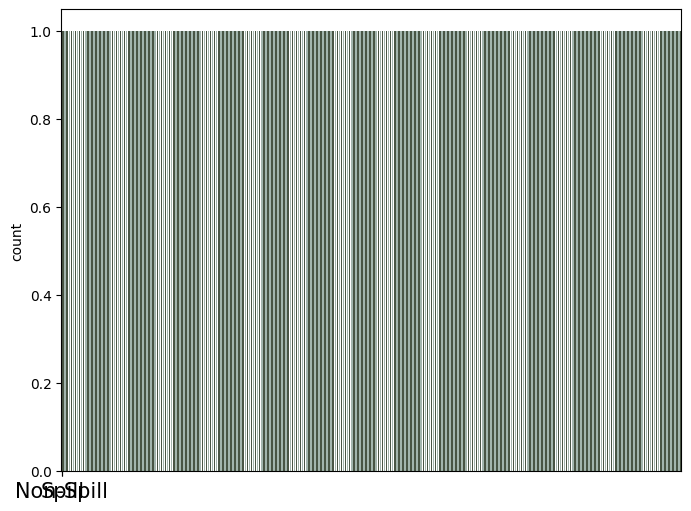

In [ ]:
_ = plt.figure(figsize=(8,6))
_ = sns.countplot(oil_df.values[:,-1], palette=['#9fb8ad','#475841'])
_ = plt.xticks([0,1],['Non-Spill','Spill'], fontsize=15)

target = oil_df.values[:,-1]
counter = Counter(target)
for k,v in counter.items():
    per = v / len(target) * 100
    print('Class=%d, Count=%d, Percentage=%.3f%%' % (k, v, per))

**MODEL TEST AND BASELINE RESULT**

In [ ]:
def evaluate_model(X, y, model):
    cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)

    metric = make_scorer(geometric_mean_score)

    scores = cross_val_score(model, X, y, scoring=metric, cv=cv, n_jobs=-1)

    return scores

X, y = oil_df.values[:,:-1], oil_df.values[:,-1]

print(X.shape, y.shape, Counter(y))

model = DummyClassifier(strategy='uniform')

scores = evaluate_model(X, y, model)

print('Mean G-Mean: %.3f (%.3f)' % (np.mean(scores), np.std(scores)))


(937, 47) (937,) Counter({0.0: 896, 1.0: 41})
Mean G-Mean: 0.502 (0.108)


**EVALUATE MODELS**

PROBABLISTIC MODELS

In [ ]:
def get_models():
    models, names = list(), list()
    # LR
    steps = [('t',StandardScaler()),('m',LogisticRegression(solver='liblinear'))]
    models.append(Pipeline(steps=steps))
    names.append('LR')

    # LDA
    steps = [('t', StandardScaler()),('m',LinearDiscriminantAnalysis())]
    models.append(Pipeline(steps=steps))
    names.append('LDA')

    # NB
    models.append(GaussianNB())
    names.append('NB')

    return models, names


models, names = get_models()

results = list()

for i in range(len(models)):
    scores = evaluate_model(X, y, models[i])
    results.append(scores)

    print('>%s %.3f (%.3f)' % (names[i], np.mean(scores), np.std(scores)))

>LR 0.672 (0.203)
>LDA 0.755 (0.147)
>NB 0.707 (0.202)


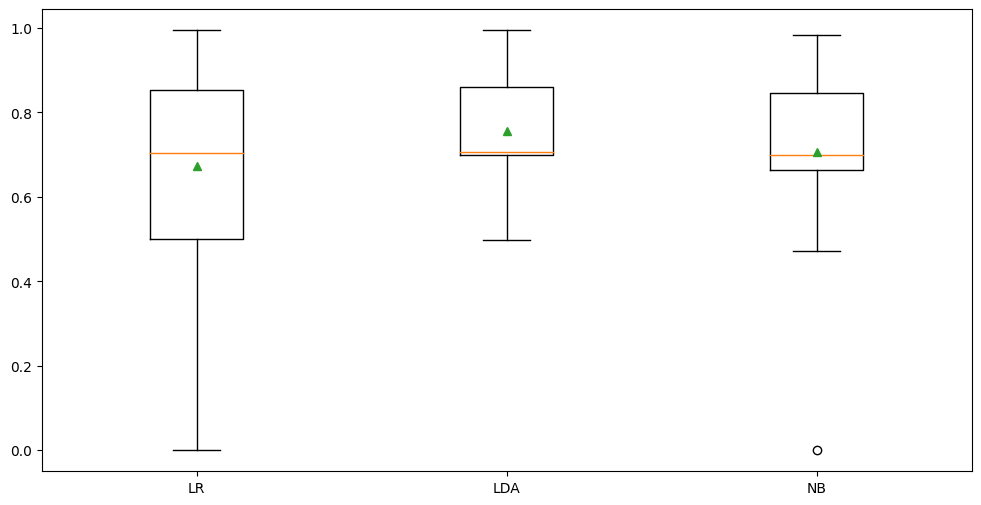

>Balanced 0.844 (0.119)
>Balanced-MinMax 0.836 (0.088)
>Balanced-Standard 0.834 (0.129)
>Balanced-PowerTransform 0.862 (0.124)
